# Demo Run

In [1]:
# %load_ext autoreload
# %autoreload 2
# # # this may cause DisentenglementTargetManager to reimported, losing all the data e.g. configurations.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import rapids_singlecell as rsc
import scanpy as sc
import cupyx as cpx
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scib
import scib_metrics

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
tardis.config = tardis.config_server

sc.settings.verbosity = 3

print(f"CUDA used: {torch.cuda.is_available()}")

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/xla.py:18: DeprecationWarning: `ModuleAvailableCache` is a special case of `RequirementCache`. Please use `RequirementCache(module=...)` instead.
  from lightning.fabric.accelerators.tpu import _XLA_AVAILABLE, TPUAccelerator
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_na

CUDA used: True


In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_Norman2019_prep_new.h5ad")
    assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
    adata = ad.read_h5ad(adata_file_path)
adata

AnnData object with n_obs × n_vars = 108497 × 5000
    obs: 'cov_drug_dose_name', 'dose_val', 'control', 'condition', 'guide_identity', 'drug_dose_name', 'cell_type', 'split', 'split1', 'split2', 'split3', 'split4', 'split5', 'split6', 'split7', 'split8', 'split9', 'split10', 'split11', 'split12', 'split13', 'split14', 'split15', 'split16', 'split17', 'split18', 'split19', 'split20', 'split21', 'split22', 'split23', 'split24', 'split25'
    var: 'gene_symbols', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'rank_genes_groups_cov'
    layers: 'counts'

In [5]:
adata.X = adata.layers["counts"].copy()
del adata.layers
gc.collect()

1708

## Train

In [6]:
warmup_epoch_range = [10, 40]
# _, n_epochs_kl_warmup = warmup_epoch_range
n_epochs_kl_warmup = 400

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "condition",
        n_reserved_latent = 12,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = 100,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = 10, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
]

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=36, 
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.1,
    include_auxillary_loss = True
)

train_params = dict(
    max_epochs=1000,
    train_size=0.8,
    batch_size=512,
    check_val_every_n_epoch=10,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=True,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-3,
        weight_decay=1e-6,
        # optimizer="AdamW"
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations
)

tardis.MyModel.setup_anndata(adata, **dataset_params)

# tardis.MyModel.setup_wandb(
#     wandb_configurations=tardis.config.wandb,
#     hyperparams=dict(
#         model_params=model_params,
#         train_params=train_params,
#         dataset_params=dataset_params,
#     )
# )

vae = tardis.MyModel(adata, **model_params)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    vae.train(**train_params)

CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Outdated CUDA installation found.
Version JAX was built against: 11080
Minimum supported: 12010
Installed version: 11080
The local installation version must be no lower than 12010.
--------------------------------------------------
Outdated cuDNN installation found.
Version JAX was built against: 8907
Minimum supported: 8900
Installed version: 8700
The local installation version must be no lower than 8900.
--------------------------------------------------
Outdated cuBLAS installation found.
Version JAX was built against: 111103
Minimum supported: 120100
Installed version: 111103
The local installation version must be no lower than 120100.
--------------------------------------------------
Outdated cuSPARSE installation found.
Version JAX was built against: 11705
Minimum supported: 12100
Installed version: 11705
The local installation version must be no lower than 12100. (Set TF_

Epoch 1/1000:   0%|                                                                                                                                                           | 0/1000 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractiveminibatchgenerator.py:63: UserWarning: Possible group definition indices are calculating for `condition` for `training` set.
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractiveminibatchgenerator.py:63: UserWarning: Number of elements in each group for `condition` in `training` set: 232,389,438,183,388,286,562,137,445,371,418,375,240,289,51,214,435,295,292,534,245,274,147,53,324,156,105,293,102,89,179,196,53,338,221,177,251,140,97,197,372,440,345,985,135,398,187,194,278,312,230,142,376,260,267,394,318,621,306,299,229,604,236,152,261,331,277,730,359,357,255,372,362,344,123,235,219,155,58,122,205,511,306,282,340,225,163,234,380,167,137,101,273,396,154,152,448,80,156,279,168,373,98,250,199,213,331,136,146,282,289,112,114,369,331,352,269,47,44,218,226,258,76,207,311,254,197,231,284,202,956,263,194,513,296,149,506,338,497,449,218,469,468,260,366,233,361,247,

Epoch 252/1000:  25%|█████████████▌                                        | 251/1000 [37:39<1:40:49,  8.08s/it, v_num=1, total_loss_train=1.17e+3, kl_local_train=34.7, tardis_condition_0_train=27.7]

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [7]:
# dir_path = os.path.join(
#     tardis.config.io_directories["models"],
#     "run7"
# )

# vae.save(
#     dir_path,
#     overwrite=False,
# )

## Load Model

In [8]:
# dir_path = os.path.join(
#     tardis.config.io_directories["models"],
#     "run7"
# )
# vae = tardis.MyModel.load(dir_path, adata=adata)

## Check training

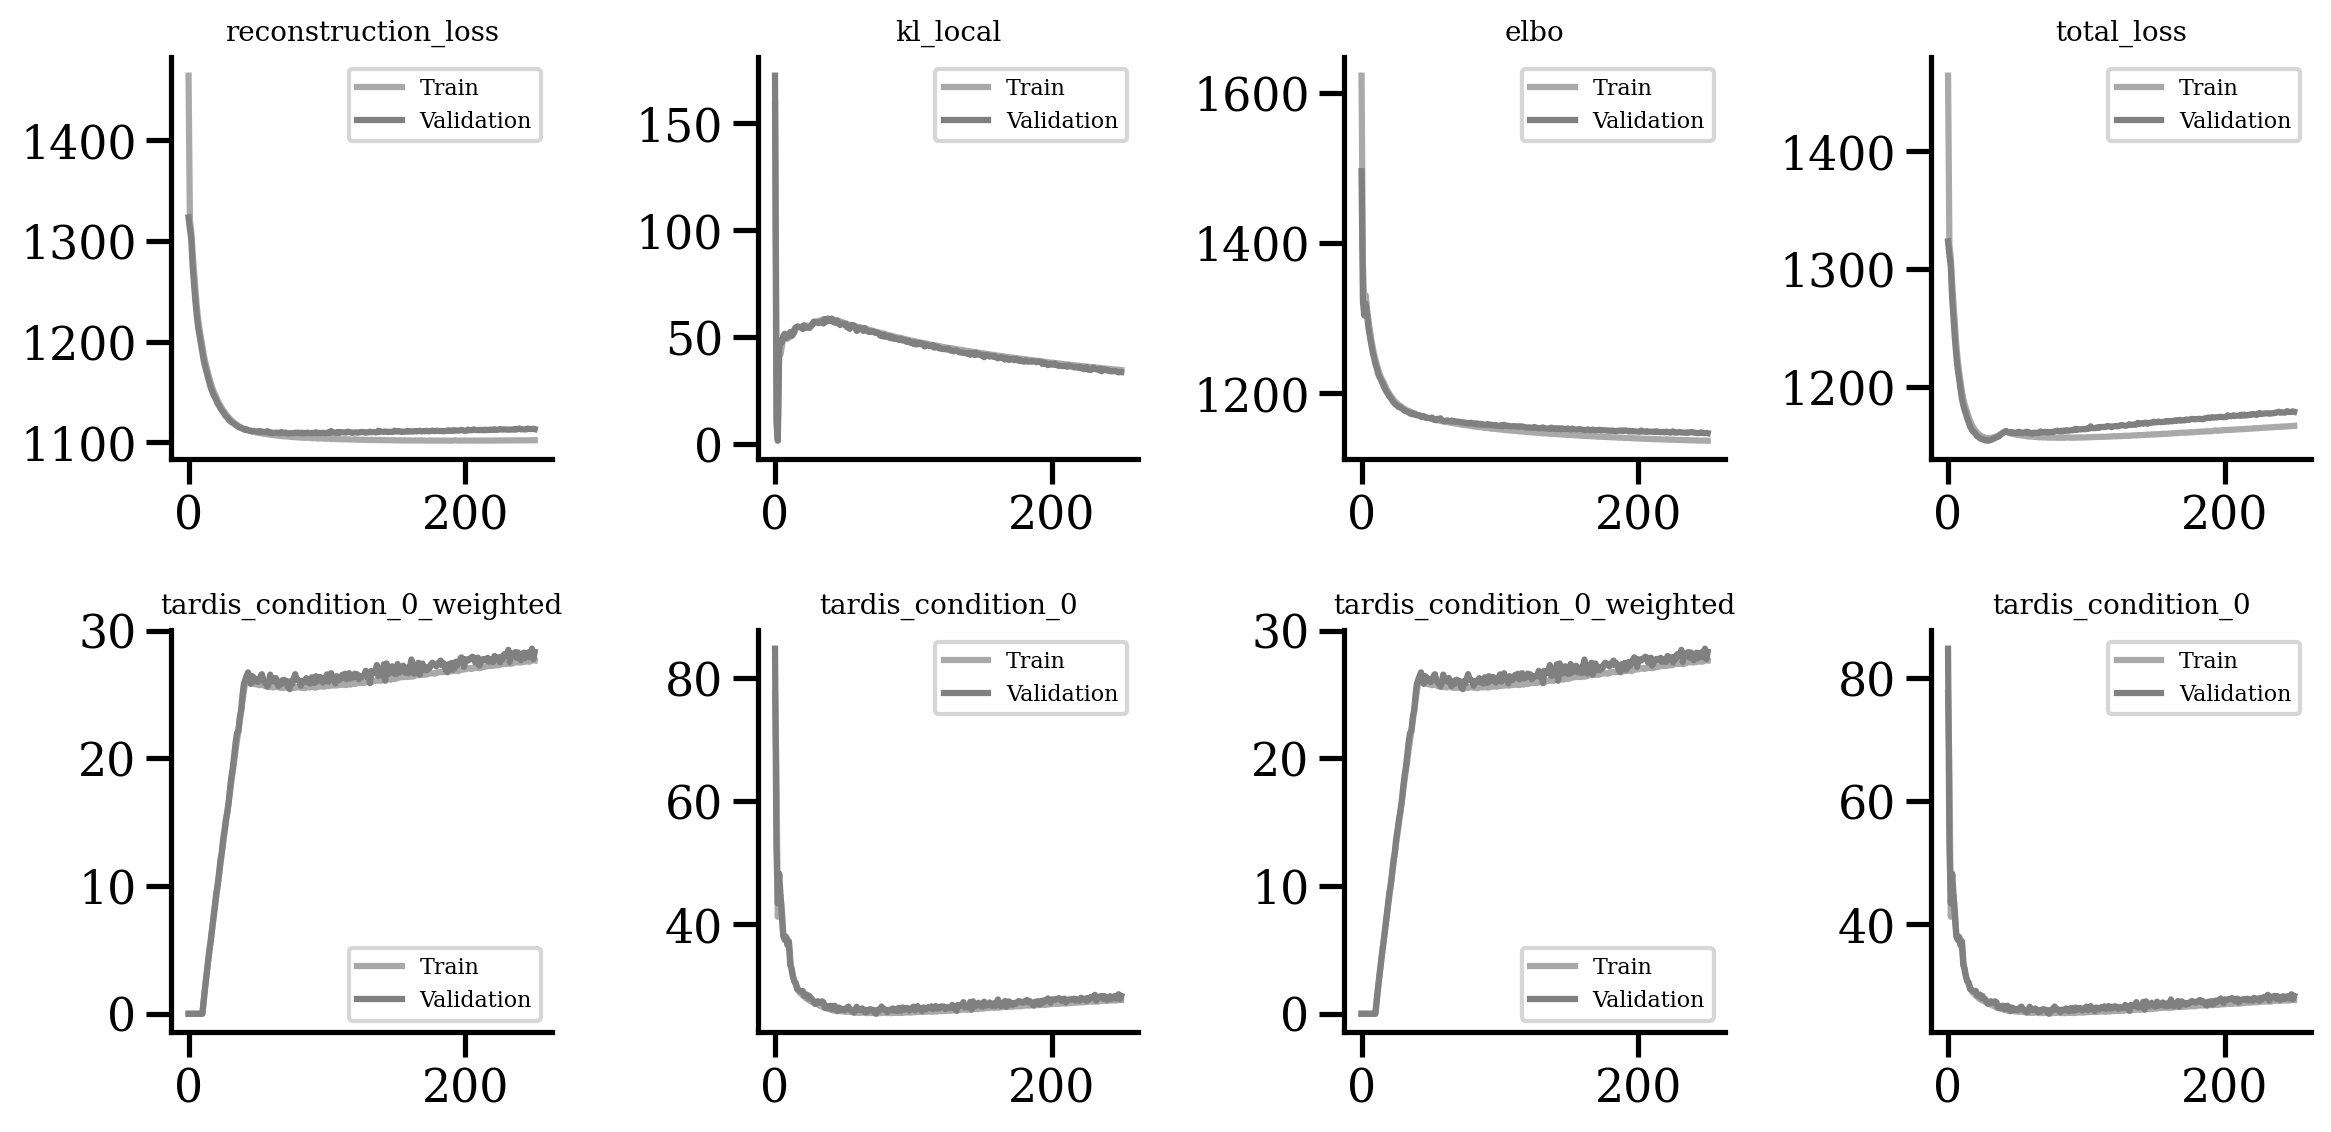

In [10]:
vae.plot_training_history(
    ignore_first=0, 
    n_col=4,
    metrics_name=[
        "reconstruction_loss", "kl_local", "elbo", "total_loss",
        #
        "tardis_condition_0_weighted", 
        "tardis_condition_0",
        "tardis_condition_0_weighted", 
        "tardis_condition_0",
    ]
)

In [11]:
# from tardis._disentenglementtargetmanager import DisentenglementTargetManager
# display(np.array(DisentenglementTargetManager.configurations.get_by_obs_key("age").reserved_latent_indices))
# display(np.array(DisentenglementTargetManager.configurations.get_by_obs_key("sex").reserved_latent_indices))

In [12]:
# vae.plot_latent_kde(
#     adata_obs=adata.obs,
#     target_obs_key="sex",
#     latent_representation=vae.get_latent_representation(),
#     latent_dim_of_interest=None
# )

# Metrics

In [13]:
batch_size_vae_metrics = 512
vae_metrics = {
    "reconstruction_error": vae.get_reconstruction_error(batch_size=batch_size_vae_metrics)['reconstruction_loss'],
    "elbo": vae.get_elbo(batch_size=batch_size_vae_metrics).item(),
    "r2_train": vae.get_reconstruction_r2(batch_size=batch_size_vae_metrics, indices=vae.train_indices),
    # "r2_train_deg_20": vae.get_reconstruction_r2(top_n_differentially_expressed_genes=20, batch_size=batch_size_vae_metrics, indices=vae.train_indices),
    # "r2_train_deg_50": vae.get_reconstruction_r2(top_n_differentially_expressed_genes=50, batch_size=batch_size_vae_metrics, indices=vae.train_indices),
    "r2_validation": vae.get_reconstruction_r2(batch_size=batch_size_vae_metrics, indices=vae.validation_indices),
    # "r2_validation_deg_20": vae.get_reconstruction_r2(top_n_differentially_expressed_genes=20, batch_size=batch_size_vae_metrics, indices=vae.validation_indices),
    # "r2_validation_deg_50": vae.get_reconstruction_r2(top_n_differentially_expressed_genes=50, batch_size=batch_size_vae_metrics, indices=vae.validation_indices),
}
for k, v in vae_metrics.items():
    print(k, v)

reconstruction_error -1100.293105742555
elbo -1134.6220703125
r2_train 0.9993875045363927
r2_validation 0.999353215089219


# Visualization

In [14]:
def prepare(ad_latent):
    sc.pp.neighbors(ad_latent, n_neighbors = 30)
    sc.tl.umap(ad_latent)

In [ ]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
prepare(latent)
latent

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:46)
computing UMAP


In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["condition", "cell_type"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [ ]:
del latent
gc.collect();

In [ ]:
from tardis._disentenglementtargetmanager import DisentenglementTargetManager
latent = ad.AnnData(X=vae.get_latent_representation()[:, DisentenglementTargetManager.configurations.get_by_obs_key("condition").unreserved_latent_indices], obs=adata.obs.copy())
prepare(latent)
display(latent.shape)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["condition", "cell_type"], 
        ncols=2,
        frameon=False,
        title="",
        legend_fontsize="xx-small"
    )

del latent
gc.collect();

In [ ]:
from tardis._disentenglementtargetmanager import DisentenglementTargetManager
latent = ad.AnnData(X=vae.get_latent_representation()[:, DisentenglementTargetManager.configurations.get_by_obs_key("condition").reserved_latent_indices], obs=adata.obs.copy())
prepare(latent)
display(latent.shape)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["condition", "cell_type"], 
        ncols=2,
        frameon=False,
        title="",
        legend_fontsize="xx-small"
    )

del latent
gc.collect();